Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


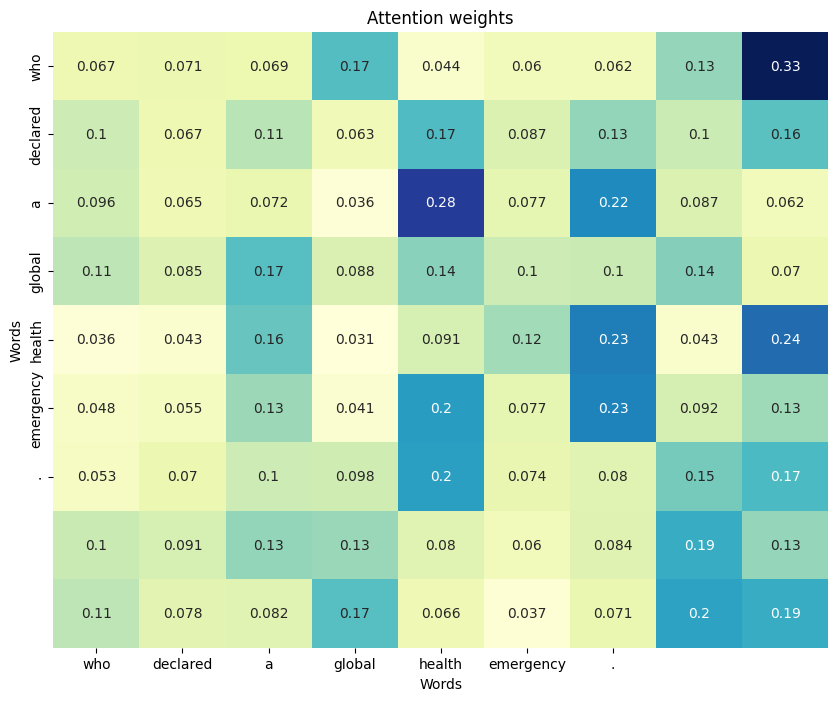

In [17]:
from transformers import BertTokenizer, BertModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Dummy sentence
sentence = "WHO declared a global health emergency."

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# Preprocess input
input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True)])

# Forward pass through the model
outputs = model(input_ids)

# Extract attention weights
attention_weights = outputs.attentions

# Visualize attention weights for the first layer and first attention head
attention_layer = 0
attention_head = 0
attention_weights_layer = attention_weights[attention_layer][0][attention_head].detach().numpy()

# Plot the attention weights using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights_layer, cmap='YlGnBu', xticklabels=tokenizer.tokenize(sentence), yticklabels=tokenizer.tokenize(sentence), cbar=False, annot=True)
plt.title("Attention weights")
plt.xlabel("Words")
plt.ylabel("Words")
plt.show()


### UI Example:

In [14]:
import gradio as gr
import numpy as np
import plotly.graph_objects as go


def generate_embeddings(sentences):
    sentences = sentences.split(";")

    # Tokenize the sentences
    if isinstance(sentences, str):
        tokenized_sentences = [tokenizer.encode(sentences, add_special_tokens=True)]
    else:
        tokenized_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences]
    
    input_tensors = [torch.tensor([input_ids]) for input_ids in tokenized_sentences]

    # Get the BERT model embeddings for the sentences
    with torch.no_grad():
        sentence_outputs = [model(input_tensor).last_hidden_state.squeeze(0).numpy() for input_tensor in input_tensors]

    # Filter out non-word tokens
    non_word_tokens = [tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id]

    filtered_sentences = []
    filtered_embeddings = []
    sentence_ids = []

    sentence_id = 0
    for sentence, input_ids in zip(sentence_outputs, tokenized_sentences):
        for i in range(len(input_ids)):
            if input_ids[i] not in non_word_tokens:
                filtered_sentences.append(tokenizer.decode(input_ids[i]))
                filtered_embeddings.append(sentence[i])
                sentence_ids.append(sentence_id)
        sentence_id += 1

    # Convert filtered embeddings to NumPy array
    filtered_embeddings = np.array(filtered_embeddings)

    return filtered_sentences, filtered_embeddings, sentence_ids



# Define the function for generating the t-SNE plot
def generate_tsne_plot(plot_type, sentences, method):

    filtered_sentences, filtered_embeddings, sentence_ids = generate_embeddings(sentences)        

    if len(filtered_sentences) > 10:
        perplexity = 6
    elif len(filtered_sentences) > 5:
        perplexity = 5
    elif len(filtered_sentences) > 1:
        perplexity = 1
    else:
        perplexity = len(filtered_sentences) - 1

    if plot_type == '3D':
        if method == 'PCA':
            # Apply PCA to reduce the dimensionality of the embeddings
            reduced_embeddings = PCA(n_components=3, random_state=42).fit_transform(filtered_embeddings)
        elif method == 't-SNE':
            # Apply t-SNE to reduce the dimensionality of the embeddings
            reduced_embeddings = TSNE(n_components=3, perplexity=perplexity, random_state=42).fit_transform(filtered_embeddings)
        elif method == 'UMAP':
            # Apply UMAP to reduce the dimensionality of the embeddings
            reduced_embeddings = UMAP(n_components=3, random_state=42).fit_transform(filtered_embeddings)

        # Create an interactive 3D scatter plot using Plotly
        fig = go.Figure(data=go.Scatter3d(
            x=reduced_embeddings[:, 0],
            y=reduced_embeddings[:, 1],
            z=reduced_embeddings[:, 2],
            mode='markers',
            text=filtered_sentences,
            marker=dict(
                size=8,
                color=sentence_ids,
                colorscale='Viridis',
                opacity=0.8
            )
        ))

    else:
        if method == 'PCA':
            # Apply PCA to reduce the dimensionality of the embeddings
            reduced_embeddings = PCA(n_components=2, random_state=42).fit_transform(filtered_embeddings)
        elif method == 't-SNE':
            # Apply t-SNE to reduce the dimensionality of the embeddings
            reduced_embeddings = TSNE(n_components=2, perplexity=perplexity, random_state=42).fit_transform(filtered_embeddings)
        elif method == 'UMAP':
            # Apply UMAP to reduce the dimensionality of the embeddings
            reduced_embeddings = UMAP(n_components=2, random_state=42).fit_transform(filtered_embeddings)

        # Create an interactive 3D scatter plot using Plotly
        fig = go.Figure(data=go.Scatter(
            x=reduced_embeddings[:, 0],
            y=reduced_embeddings[:, 1],
            mode='markers',
            text=filtered_sentences,
            marker=dict(
                size=8,
                color=sentence_ids,
                colorscale='Viridis',
                opacity=0.8
            )
        ))
    
    # Set plot layout
    fig.update_layout(
        title=f"BERT Embeddings - {method} {plot_type} Visualization",
        scene=dict(
        )
    )    

    # Return the plot figure as an HTML string
    return fig


with gr.Blocks() as demo:
    button = gr.Radio(label="Plot type",
                        choices=['3D', '2D'], value='3D')
    
    method = gr.Radio(label="Dimensionality Reduction Method",
                        choices=['t-SNE', 'PCA', 'UMAP'], value='t-SNE')

    # Define the input component
    input_text = gr.Textbox(lines=3, label="Enter Sentences separated by ;", value="He is a nurse; She is a nurse")

    # Define the button component
    btn = gr.Button(value="Run")

    # Define the output component
    plot = gr.Plot(label="Embeddings Plot")

    # if plot changes, run the function
    button.change(generate_tsne_plot, inputs=[button, input_text, method], outputs=[plot])

    # if plot changes, run the function
    method.change(generate_tsne_plot, inputs=[button, input_text, method], outputs=[plot])

    # If button is clicked, run the function
    btn.click(generate_tsne_plot, inputs=[button, input_text, method], outputs=[plot])

    # load the interface:
    demo.load(generate_tsne_plot, inputs=[button, input_text, method], outputs=[plot])

    # Run the interface
    demo.launch()


Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/davidrestrepo/miniforge3/envs/transformers/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/Users/davidrestrepo/miniforge3/envs/transformers/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/Users/davidrestrepo/miniforge3/envs/transformers/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/Users/davidrestrepo/miniforge3/envs/transformers/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1

/Users/davidrestrepo/miniforge3/envs/transformers/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size